## Imports

In [5]:
from transformers import pipeline
from datasets import load_dataset
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

## Use vision model from huggingface - food classification

In [2]:
pipe = pipeline("image-classification", device='cuda', model="Shresthadev403/food-image-classification")
ds = load_dataset("ethz/food101")
ds = ds.shuffle(seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

## Define grid functions

In [47]:
@dataclass
class Grid:
    array: np.array
    number_of_regions: int
    h: int
    w: int

class SubImage:
    def __init__(self, grid: Grid):
        self.selected = np.random.random_sample(size=grid.number_of_regions) < 0.5
        self.grid = grid

def get_sides(number_of_regions: int):
    if number_of_regions <= 3:
        raise ValueError(f"Provide number greater than 3")
    for i in range(int(number_of_regions ** 0.5 + 1), 1, -1):
        if number_of_regions % i == 0:
            return i, number_of_regions // i
    raise ValueError(f"{number_of_regions} is prime, provide not prime number")

def calculate_regions(image, number_of_regions):
    h, w = get_sides(number_of_regions)

    grid = []
    parts = np.array_split(image, h)
    for part in parts:
        grid.append(np.array_split(part, w, axis=1))
    return Grid(grid, number_of_regions, h, w)

def visualize_grid(grid: Grid, condition = lambda i, j: True):
    f, axs = plt.subplots(grid.h, grid.w)
    for i, row in enumerate(grid.array):
        for j, element in enumerate(row):
            if condition(i, j):
                axs[i, j].imshow(element)

            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i, j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def visualize_sub_image(sub_image: SubImage):
    grid = sub_image.grid
    visualize_grid(sub_image.grid, lambda i, j: sub_image.selected[i * sub_image.grid.h + j])

## Task implementation

1. Calculate the predictions for selected observations

In [43]:
number_of_observations = 1
examples = ds['train'][:number_of_observations]
predictions = [pred[0] for pred in pipe(examples['image'])]
predictions

[{'label': 'peking_duck', 'score': 0.9999945163726807}]

2. Then, calculate 20-50 regions for a given image. Divide the image in a grid of rectangles.

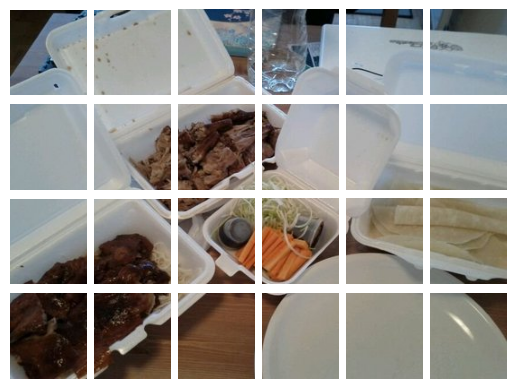

In [45]:
number_of_regions = 24
regions = [calculate_regions(np.array(img), number_of_regions) for img in examples['image']]
visualize_grid(regions[0])

3. Generate N (100-1000 depending) subimages with randomly selected parts of an image. Calculate predictions for these parts.

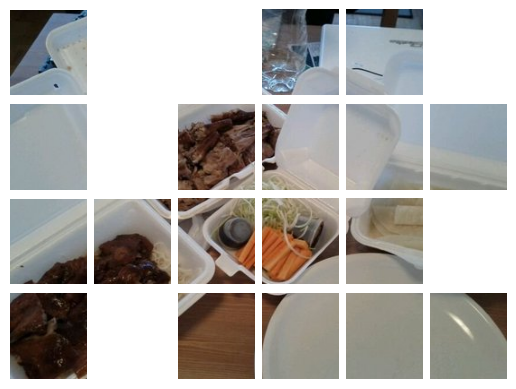

In [56]:
visualize_sub_image(SubImage(regions[0]))

4. Calculate LIME explanations 